In [1]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()
# Dense layer
class Layer_Dense :
# Layer initialization
    def __init__ ( self , n_inputs , n_neurons , weight_regularizer_l1 = 0, weight_regularizer_l2 = 0, bias_regularizer_l1 = 0, bias_regularizer_l2 =0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros(( 1 , n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
        #set regularization strength
    # Forward pass
    def forward ( self , inputs ):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    # Backward pass
    def backward ( self , dvalues ):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0 , keepdims = True )
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)
        #Gradients on regularization
        #L1 on weights

        if self.weight_regularizer_l1 >0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights <0 ] =-1
            self.dweights += self.weight_regularizer_l1 * dL1
        #l2 on weights
        if self.weight_regularizer_l2 >0:
            self.dweights += 2*self.weight_regularizer_l2 * self.weights

        #L1 regularization - biases

        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases< 0 ] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        #l2 on biases
        if self.bias_regularizer_l2> 0:
            self.dbiases +=  2 * self.bias_regularizer_l2 * self.biases
        #Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

class Layer_Dropout:
    #init
    def __init__(self, rate):
        #store the rate, we intert it as for example for dropout of 0.1, we need success rate of 0.9
        self.rate = 1 - rate

    def forward(self, inputs):
        #save input values
        self.inputs = inputs
        #Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate, size = inputs.shape) / self.rate
        #apply mask to output value
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        #gradient on values
        self.dinputs = dvalues * self.binary_mask


    # ReLU activation
class Activation_ReLU :
    # Forward pass
    def forward ( self , inputs ):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum( 0 , inputs)
        # Backward pass
    def backward ( self , dvalues ):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0 ] = 0
    # Softmax activation

class Activation_Softmax :
    # Forward pass
    def forward ( self , inputs ):
        # Remember input values
        self.inputs = inputs
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis = 1 ,
        keepdims = True ))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis = 1 ,
        keepdims = True )
        self.output = probabilities
        # Backward pass
    def backward ( self , dvalues ):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
        enumerate ( zip (self.output, dvalues)):
        # Flatten output array
            single_output = single_output.reshape( - 1 , 1 )
            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - \
            np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
            single_dvalues)

class Activation_Sigmoid:
    #forward pass
    def forward(self, inputs):
        #save input and calculate / save output
        #ot the sigmoid function

        self.inputs = inputs
        self.output = 1/ (1 + np.exp(-inputs))

    def backward(self, dvalues):
        #derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1- self.output) * self.output

class Optimizer_SGD:
    #Initialize optimizer - set settings,
    #learning rate of 1 is default for this optimizer

    def __init__(self, learning_rate = 1, decay = 0, momentum = 0):
        self.name = "optimizerSGD"
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        #if later does not contain momentum arrays, create them
        #filled them with zeros
        if self.momentum:

            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                #if there is no momentum array for weights
                #the array does not exist for biases yet either
                layer.bias_momentums = np.zeros_like(layer.biases)

            #Build weight updates with momentum - take previous
            #updates multiplied by retain factor and update with
            #current gradients

            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            #build bias updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentum = bias_updates
            
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases


        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

    def post_update_params(self):
        self.iterations += 1

class Optimizer_Adagrad :
    # Initialize optimizer - set settings
    def __init__ ( self , learning_rate = 1. , decay = 0. , epsilon = 1e-7 ):
        self.name = "OptimizerAdagrad"
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
    # Call once before any parameter updates
    def pre_update_params ( self ):
        if self.decay:
            self.current_learning_rate = self.learning_rate *  ( 1. / ( 1. + self.decay * self.iterations))
        
    # Update parameters
    def update_params ( self , layer ):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr (layer, 'weight_cache' ):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2
        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += - self.current_learning_rate * layer.dweights /  (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += - self.current_learning_rate *  layer.dbiases /       (np.sqrt(layer.bias_cache) + self.epsilon)
        # Call once after any parameter updates
    def post_update_params ( self ):
        self.iterations += 1

class Optimizer_RMSprop:

    def __init__(self, learning_rate = 0.001, decay = 0, epsilon = 1e-7, rho=0.9):
        self.name = "RMSProp"
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
    
    #Update parameters
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):

        #if layer does not contain cache arrays
        #create them filled with zeros

        if not hasattr(layer, 'weight_cache'): 
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        #update cache with squared current gradient
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache =  self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases ** 2

        layer.weights += - self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += - self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1

class Optimizer_Adam:

    def __init__(self, learning_rate = 0.001, decay = 0, epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
        self.name = "OptimizerAdam"
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.iterations = 0
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        #if layer does not contain cache arrays
        #create them filled with zeros

        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            

        layer.weight_momentums = self.beta_1 * layer.weight_momentums  + (1- self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1- self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / ( 1 - self.beta_1 ** (self.iterations + 1 ))
        bias_momentums_corrected = layer.bias_momentums / ( 1 - self.beta_1 ** (self.iterations + 1 ))
# Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + ( 1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + ( 1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corrected = layer.weight_cache / ( 1 - self.beta_2 ** (self.iterations + 1 ))
        bias_cache_corrected = layer.bias_cache / ( 1 - self.beta_2 ** (self.iterations + 1 ))

        layer.weights += - self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += - self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    def post_update_params ( self ):
        self.iterations += 1

# Common loss class
class Loss :

    #Regularization on loss calculation

    def regularization_loss(self, layer):
        #0 by default

        regularization_loss = 0
        #L1 regularization-weights
        #calculate only when factor greater than 0
        #L1 regularization’s penalty is the sum of all the absolute values for the weights and biases.
        #This is a linear penalty as regularization loss returned by this function is directly proportional to
        #parameter values. L2 regularization’s penalty is the sum of the squared weights and biases.


        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

        #L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizerl2 * np.sum(layer.weights*layer.weights)

        #L1 regularization - biases
        #calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        #L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss       

        
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate ( self , output , y ):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss
        # Cross-entropy loss

class Loss_CategoricalCrossentropy ( Loss ):
    # Forward pass
    def forward ( self , y_pred , y_true ):
    # Number of samples in a batch
        samples = len (y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7 , 1 - 1e-7 )
        # Probabilities for target values -
        # only if categorical labels
        if len (y_true.shape) == 1 :
            correct_confidences = y_pred_clipped[
            range (samples),
            y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len (y_true.shape) == 2 :
            correct_confidences = np.sum(
            y_pred_clipped * y_true,
            axis = 1
            )
    # Losses
        negative_log_likelihoods = - np.log(correct_confidences)
        return negative_log_likelihoods
        # Backward pass
    def backward ( self , dvalues , y_true ):
        # Number of samples
        samples = len (dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len (dvalues[ 0 ])
        # If labels are sparse, turn them into one-hot vector
        if len (y_true.shape) == 1 :
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = - y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy ():
    # Creates activation and loss function objects
    def __init__ ( self ):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        # Forward pass
    def forward ( self , inputs , y_true ):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    # Backward pass
    def backward ( self , dvalues , y_true ):
        # Number of samples
        samples = len (dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len (y_true.shape) == 2 :
            y_true = np.argmax(y_true, axis = 1 )
            # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[ range (samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


class Loss_BinaryCrossentropy(Loss):
    
    #forward pass
    def forward(self, y_pred, y_true):
        #clip data to prevent division by 0
        #clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        #calculate sample-wise loss

        sample_losses = -(y_true * np.log(y_pred_clipped)+ (1 - y_true) * np.log(1- y_pred_clipped) )
        sample_losses = np.mean(sample_losses, axis = 1)

        return sample_losses
    
    def backward(self, dvalues, y_true):
        #Number of samples

        samples = len(dvalues)

        #number of outputs in every sample
        #well use the first sample to count them

        outputs = len(dvalues[0])

        #clip data to prevent division by 0
        #clip both sides to not drag mean towards any value

        clipped_dvalues = np.clip(dvalues, 1e-7, 1-1e-7)

        #calculate gradient
        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / outputs

        #Normalize gradient
        self.dinputs = self.dinputs / samples

        
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):

    #calculate Loss
        sample_losses = np.mean((y_true - y_pred)** 2, axis = -1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        #Number of samples
        samples = len(dvalues)

        #number of outputs in every sample
        #we'll use the first sample to count them
        outputs = len(dvalues[0])

        #Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        
        #normalize gradient
        self.dinputs = self.dinputs / samples

class Loss_MeanAbsoluteError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis = -1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        #Number of samples
        samples = len(dvalues)

        #Number of outputs in every samples
        #We'll use the first sample to count them
        outputs = len(dvalues[0])

        #calculate gradient
        self.dinputs = np.sign(y_true - dvalues)/ outputs

        #normalize gradient
        self.dinputs = self.dinputs / samples

        



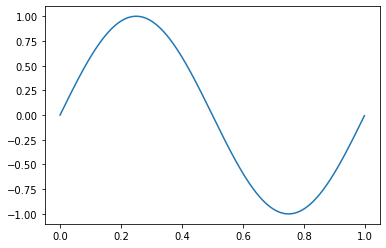

In [2]:
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import sine_data
nnfs.init()

X,y = sine_data()
plt.plot(X,y)
plt.show()

In [3]:
X,y = sine_data()

dense1 = Layer_Dense(1,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,1)
activation2 = Activation_Linear()

loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam()

accuracy_precision = np.std(y) / 250

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    data_loss = loss_function.calculate(activation2.output, y)

    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2)

    loss = data_loss + regularization_loss

    predictions = activation2.output
    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)

    if not epoch % 100 :
        print ( f'epoch: {epoch} , ' +
                f'acc: {accuracy :.3f} , ' +
                f'loss: {loss :.3f} (' +
                f'data_loss: {data_loss :.3f} , ' +
                f'reg_loss: {regularization_loss :.3f} ), ' +
                f'lr: {optimizer.current_learning_rate} ' )

#backward pass

    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    #Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()



epoch: 0 , acc: 0.002 , loss: 0.500 (data_loss: 0.500 , reg_loss: 0.000 ), lr: 0.001 
epoch: 100 , acc: 0.003 , loss: 0.346 (data_loss: 0.346 , reg_loss: 0.000 ), lr: 0.001 
epoch: 200 , acc: 0.004 , loss: 0.163 (data_loss: 0.163 , reg_loss: 0.000 ), lr: 0.001 
epoch: 300 , acc: 0.003 , loss: 0.147 (data_loss: 0.147 , reg_loss: 0.000 ), lr: 0.001 
epoch: 400 , acc: 0.003 , loss: 0.146 (data_loss: 0.146 , reg_loss: 0.000 ), lr: 0.001 
epoch: 500 , acc: 0.003 , loss: 0.146 (data_loss: 0.146 , reg_loss: 0.000 ), lr: 0.001 
epoch: 600 , acc: 0.004 , loss: 0.146 (data_loss: 0.146 , reg_loss: 0.000 ), lr: 0.001 
epoch: 700 , acc: 0.003 , loss: 0.146 (data_loss: 0.146 , reg_loss: 0.000 ), lr: 0.001 
epoch: 800 , acc: 0.004 , loss: 0.146 (data_loss: 0.146 , reg_loss: 0.000 ), lr: 0.001 
epoch: 900 , acc: 0.004 , loss: 0.146 (data_loss: 0.146 , reg_loss: 0.000 ), lr: 0.001 
epoch: 1000 , acc: 0.004 , loss: 0.146 (data_loss: 0.146 , reg_loss: 0.000 ), lr: 0.001 
epoch: 1100 , acc: 0.003 , loss: 

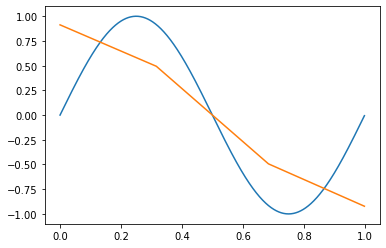

In [4]:
import matplotlib.pyplot as plt
X_test, y_test = sine_data()

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)

plt.plot(X_test, y_test)
plt.plot(X_test, activation2.output)
plt.show()

In [5]:
X,y = sine_data()

dense1 = Layer_Dense(1,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64,1)
activation3 = Activation_Linear()


loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam()

accuracy_precision = np.std(y) / 250

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    data_loss = loss_function.calculate(activation3.output, y)

    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2) + loss_function.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)

    if not epoch % 100 :
        print ( f'epoch: {epoch} , ' +
                f'acc: {accuracy :.3f} , ' +
                f'loss: {loss :.3f} (' +
                f'data_loss: {data_loss :.3f} , ' +
                f'reg_loss: {regularization_loss :.3f} ), ' +
                f'lr: {optimizer.current_learning_rate} ' )

#backward pass

    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    #Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense2)
    optimizer.post_update_params()



epoch: 0 , acc: 0.002 , loss: 0.500 (data_loss: 0.500 , reg_loss: 0.000 ), lr: 0.001 
epoch: 100 , acc: 0.002 , loss: 0.458 (data_loss: 0.458 , reg_loss: 0.000 ), lr: 0.001 
epoch: 200 , acc: 0.003 , loss: 0.374 (data_loss: 0.374 , reg_loss: 0.000 ), lr: 0.001 
epoch: 300 , acc: 0.003 , loss: 0.280 (data_loss: 0.280 , reg_loss: 0.000 ), lr: 0.001 
epoch: 400 , acc: 0.003 , loss: 0.204 (data_loss: 0.204 , reg_loss: 0.000 ), lr: 0.001 
epoch: 500 , acc: 0.003 , loss: 0.143 (data_loss: 0.143 , reg_loss: 0.000 ), lr: 0.001 
epoch: 600 , acc: 0.004 , loss: 0.108 (data_loss: 0.108 , reg_loss: 0.000 ), lr: 0.001 
epoch: 700 , acc: 0.005 , loss: 0.095 (data_loss: 0.095 , reg_loss: 0.000 ), lr: 0.001 
epoch: 800 , acc: 0.007 , loss: 0.092 (data_loss: 0.092 , reg_loss: 0.000 ), lr: 0.001 
epoch: 900 , acc: 0.006 , loss: 0.091 (data_loss: 0.091 , reg_loss: 0.000 ), lr: 0.001 
epoch: 1000 , acc: 0.006 , loss: 0.090 (data_loss: 0.090 , reg_loss: 0.000 ), lr: 0.001 
epoch: 1100 , acc: 0.006 , loss: 

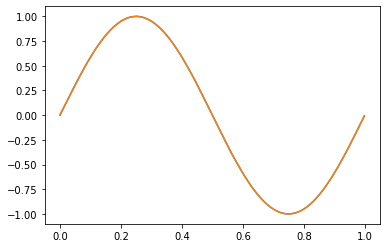

In [6]:
import matplotlib.pyplot as plt
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()

In [7]:
X,y = sine_data()

dense1 = Layer_Dense(1,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64,1)
activation3 = Activation_Linear()


loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam(learning_rate = 0.01, decay = 1e-3)

accuracy_precision = np.std(y) / 250

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    data_loss = loss_function.calculate(activation3.output, y)

    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2) + loss_function.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)

    if not epoch % 100 :
        print ( f'epoch: {epoch} , ' +
                f'acc: {accuracy :.3f} , ' +
                f'loss: {loss :.3f} (' +
                f'data_loss: {data_loss :.3f} , ' +
                f'reg_loss: {regularization_loss :.3f} ), ' +
                f'lr: {optimizer.current_learning_rate} ' )

#backward pass

    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    #Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense2)
    optimizer.post_update_params()



epoch: 0 , acc: 0.002 , loss: 0.500 (data_loss: 0.500 , reg_loss: 0.000 ), lr: 0.01 
epoch: 100 , acc: 0.003 , loss: 0.236 (data_loss: 0.236 , reg_loss: 0.000 ), lr: 0.009099181073703368 
epoch: 200 , acc: 0.004 , loss: 0.180 (data_loss: 0.180 , reg_loss: 0.000 ), lr: 0.008340283569641367 
epoch: 300 , acc: 0.005 , loss: 0.093 (data_loss: 0.093 , reg_loss: 0.000 ), lr: 0.007698229407236336 
epoch: 400 , acc: 0.006 , loss: 0.088 (data_loss: 0.088 , reg_loss: 0.000 ), lr: 0.007147962830593281 
epoch: 500 , acc: 0.006 , loss: 0.078 (data_loss: 0.078 , reg_loss: 0.000 ), lr: 0.0066711140760507 
epoch: 600 , acc: 0.009 , loss: 0.062 (data_loss: 0.062 , reg_loss: 0.000 ), lr: 0.006253908692933083 
epoch: 700 , acc: 0.015 , loss: 0.047 (data_loss: 0.047 , reg_loss: 0.000 ), lr: 0.005885815185403178 
epoch: 800 , acc: 0.020 , loss: 0.026 (data_loss: 0.026 , reg_loss: 0.000 ), lr: 0.005558643690939411 
epoch: 900 , acc: 0.033 , loss: 0.013 (data_loss: 0.013 , reg_loss: 0.000 ), lr: 0.0052659294

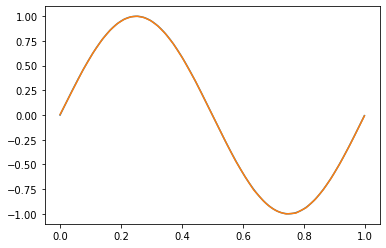

In [8]:
import matplotlib.pyplot as plt
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()